# Aerial Road Damages Multi-label-Multi-Class Classification

### Overview:
This project explores the application of state-of-the-art deep learning models—ResNet50, InceptionV3, and VGG16—to automate the detection and classification of road damage from images. Utilizing a dataset of 4004 labeled road images, the models are trained to identify and assess 26 different types of road damage, with severity levels ranging from 0 to 5. The goal is to enhance infrastructure maintenance by providing accurate, scalable solutions for road condition monitoring.

### Objectives:
Develop a Multi-Label Classification Model: Train deep learning models to predict multiple road damage types and their severity levels.
Compare Model Performance: Evaluate the effectiveness of ResNet50, InceptionV3, and VGG16 in terms of accuracy, precision, recall, and F2-score.
Visualize Key Metrics: Generate insightful visualizations, including loss curves and confusion matrices, to analyze model performance.

### Key Features:
Data Preprocessing: Normalization and resizing of road images for model compatibility.
Model Training: Implementation of custom training loops with loss tracking and validation.
Performance Metrics: Detailed evaluation of each model's ability to accurately classify road damage.
Visual Insights: Loss curves, confusion matrices, and metric comparisons to showcase model capabilities.

In [1]:
!pip install torch torchvision pandas scikit-learn


### Importing Libraries

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
csv_file_path = '/content/drive/MyDrive/Test_Pot_4K.csv'

In [6]:
data = pd.read_csv(csv_file_path, header=None)

# Extract the column names from the first row
column_names = data.iloc[0].str.split(',', expand=True).values.flatten()

# Extract the data starting from the second row
data = data.iloc[1:].copy()

# Function to split a row into the first 33 columns and the LINESTRING columns
def split_row(row):
    # Split by commas, this will handle the first 33 columns
    split_values = row.split(',', 33)

    # The first 33 columns are directly split
    first_33 = split_values[:33]

    # The remaining part is for the LINESTRING columns, joined together
    remaining_part = split_values[33] if len(split_values) > 33 else ""

    # Extract LINESTRING_1 and LINESTRING_2 based on the presence of two LINESTRING parts
    linestrings = re.findall(r'\"LINESTRING[^"]+\"', remaining_part)
    linestring_1 = linestrings[0] if len(linestrings) > 0 else None
    linestring_2 = linestrings[1] if len(linestrings) > 1 else None

    return first_33 + [linestring_1, linestring_2]

# Apply the custom split function to each row
data_split = data[0].apply(split_row)

# Convert the split data into a DataFrame
data_split_df = pd.DataFrame(data_split.tolist())

# Assign the correct column names (assuming the last two columns are for LINESTRING data)
data_split_df.columns = column_names[:33].tolist() + ["geometry", "geoseg"]

# Display the first few rows to verify the correct splitting
print(data_split_df.head())

data = data_split_df

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

  image_n index surface_failures_d surface_failures_e failures_potholes_d  \
0       0  1021                5.0                4.0                 5.0   
1       1  1022                5.0                4.0                 5.0   
2       2  1023                5.0                4.0                 5.0   
3       3  1024                5.0                4.0                 5.0   
4       4  1025                5.0                4.0                 5.0   

  failures_potholes_e stone_loss_d stone_loss_e bleeding_d bleeding_e  ...  \
0                 2.0          0.0          0.0        0.0        0.0  ...   
1                 2.0          0.0          0.0        0.0        0.0  ...   
2                 2.0          0.0          0.0        0.0        0.0  ...   
3                 2.0          0.0          0.0        0.0        0.0  ...   
4                 2.0          0.0          0.0        0.0        0.0  ...   

  edge_breaks_e patching_d patching_e road_width_m width_m lanes  \


In [7]:
# Get some information about the data
print(data.info())

# Check the columns to understand the structure
print(data.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   image_n                  4004 non-null   object
 1   index                    4004 non-null   object
 2   surface_failures_d       4004 non-null   object
 3   surface_failures_e       4004 non-null   object
 4   failures_potholes_d      4004 non-null   object
 5   failures_potholes_e      4004 non-null   object
 6   stone_loss_d             4004 non-null   object
 7   stone_loss_e             4004 non-null   object
 8   bleeding_d               4004 non-null   object
 9   bleeding_e               4004 non-null   object
 10  block_cracks_d           4004 non-null   object
 11  block_cracks_e           4004 non-null   object
 12  longitudinal_cracks_d    4004 non-null   object
 13  longitudinal_cracks_e    4004 non-null   object
 14  transverse_cracks_d      4004 non-null  

### Display 5 random images to cheeck if loaded correctly

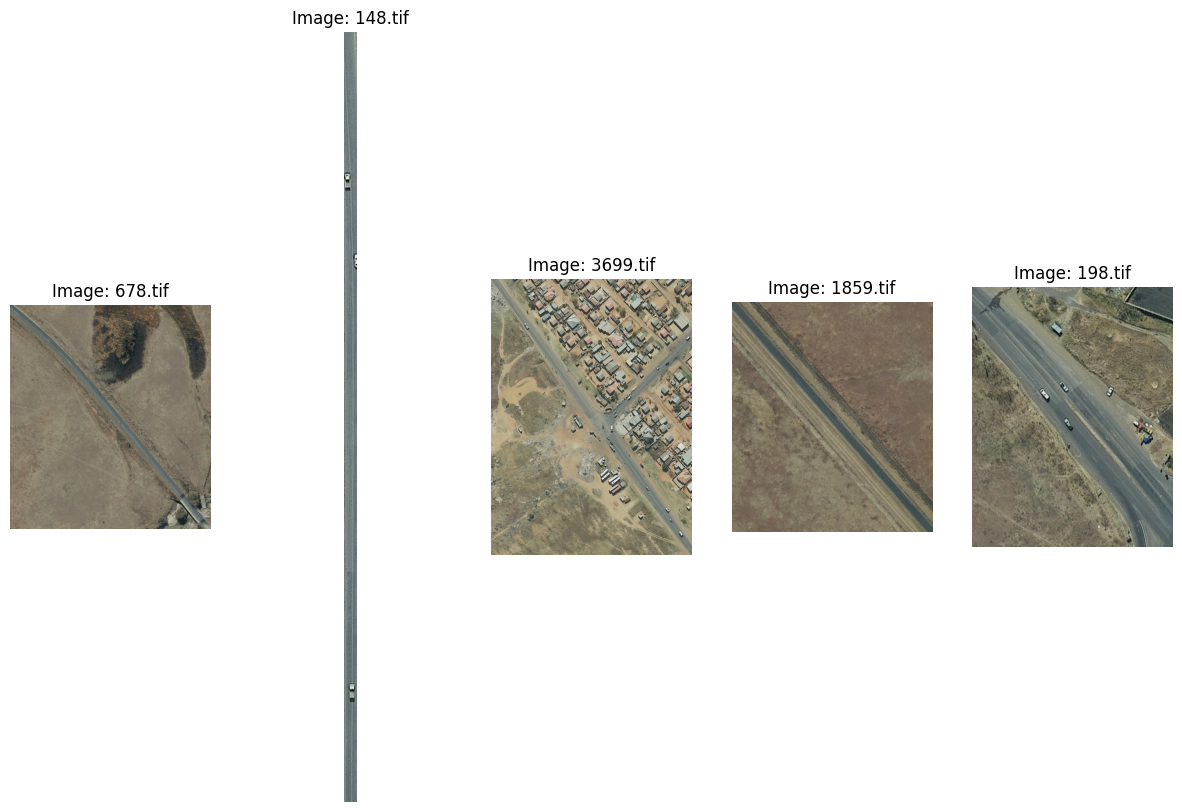

In [8]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Directory where your images are stored
img_dir = '/content/drive/MyDrive/Test_Pot_4K_Images/'

# Function to display random images from the folder
def show_random_images_from_folder(img_dir, num_images=5):
    # Get a list of all image filenames in the directory
    all_images = [f for f in os.listdir(img_dir) if f.endswith('.tif')]

    # Randomly select a few images
    selected_images = random.sample(all_images, num_images)

    # Display the images
    plt.figure(figsize=(15, 10))

    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(f"Image: {img_name}")
        plt.axis('off')

    plt.show()

# Display 5 random images from the folder
show_random_images_from_folder(img_dir, num_images=5)



In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd

class RoadDamageDataset(Dataset):
    def __init__(self, csv_file_or_df, img_dir, damage_columns, transform=None):
        # Check if the input is a path to a CSV file or a DataFrame
        if isinstance(csv_file_or_df, str):
            self.annotations = pd.read_csv(csv_file_or_df, delimiter=';')
        else:
            self.annotations = csv_file_or_df
        self.img_dir = img_dir
        self.damage_columns = damage_columns
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        # Use the correct column name here
        img_name = str(self.annotations.iloc[index]['image_n']) + '.tif'
        img_path = os.path.join(self.img_dir, img_name)

        # Attempt to open the image file and handle the case where it might be missing
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: {img_path} not found. Skipping this image.")
            return None  # You can handle this more gracefully in the dataloader


        # Get the labels for the 26 damage types from the CSV file
        labels = self.annotations.iloc[index][self.damage_columns].values.astype('float')

        # Apply any transformations to the image
        if self.transform:
            image = self.transform(image)

        # Convert labels to LongTensor
        return image, torch.tensor(labels, dtype=torch.long)


### Transformation for resnet50

In [10]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the size expected by ResNet
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet statistics
])


In [11]:
img_dir = '/content/drive/MyDrive/Test_Pot_4K_Images/'  # Path to your image folder
csv_file_path = '/content/drive/MyDrive/Test_Pot_4K.csv'  # Path to your CSV file
damage_columns = ['surface_failures_d', 'surface_failures_e', 'failures_potholes_d', 'failures_potholes_e',
                  'stone_loss_d', 'stone_loss_e', 'bleeding_d', 'bleeding_e', 'block_cracks_d', 'block_cracks_e',
                  'longitudinal_cracks_d', 'longitudinal_cracks_e', 'transverse_cracks_d', 'transverse_cracks_e',
                  'crocodile_creacks_d', 'crocodile_cracks_e', 'pumping_d', 'pumping_e', 'rutting_d', 'rutting_e',
                  'undulation_settlement_d', 'undulation_settlement_e', 'edge_breaks_d', 'edge_breaks_e',
                  'patching_d', 'patching_e']

# Create datasets
train_dataset = RoadDamageDataset(csv_file_or_df=train_data, img_dir=img_dir, damage_columns=damage_columns, transform=transform)
test_dataset = RoadDamageDataset(csv_file_or_df=test_data, img_dir=img_dir, damage_columns=damage_columns, transform=transform)


# DataLoader to handle batching
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)



# Resnet50

In [12]:
# To Track Progress
!pip install tqdm

### Training Loop ResNet50

In [13]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, fbeta_score, accuracy_score

# Define the model, criterion, and optimizer
model_resnet50 = models.resnet50(pretrained=True)

# Replace the final fully connected layer
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, 26 * 6)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet50 = model_resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=0.001)

# Track metrics
train_loss_resnet50 = []
val_loss_resnet50 = []
accuracy_resnet50 = []
precision_resnet50 = []
recall_resnet50 = []
f2_score_resnet50 = []

def train_resnet50(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            outputs = outputs.view(-1, 6)  # Flatten to [batch_size * 26, 6]
            labels = labels.view(-1)  # Flatten to [batch_size * 26]

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': running_loss/len(dataloader)})

        # Store the loss for this epoch
        epoch_loss = running_loss / len(dataloader)
        train_loss_resnet50.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

        # Validate at the end of each epoch (if you have a validation set)
        val_loss, val_acc, val_prec, val_rec, val_f2 = validate_resnet50(model, test_loader, criterion)
        val_loss_resnet50.append(val_loss)
        accuracy_resnet50.append(val_acc)
        precision_resnet50.append(val_prec)
        recall_resnet50.append(val_rec)
        f2_score_resnet50.append(val_f2)

    return train_loss_resnet50, val_loss_resnet50

def validate_resnet50(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.view(-1, 6)
            labels = labels.view(-1)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f2 = fbeta_score(all_labels, all_predictions, beta=2, average='macro')

    return val_loss/len(val_loader), accuracy, precision, recall, f2

# Train the model using the train_loader
train_loss_resnet50, val_loss_resnet50 = train_resnet50(model_resnet50, train_loader, criterion, optimizer, num_epochs=10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 101/101 [02:47<00:00,  1.66s/it, Loss=0.911]


Epoch [1/10], Loss: 0.9114


Epoch 2/10: 100%|██████████| 101/101 [01:40<00:00,  1.01it/s, Loss=0.891]


Epoch [2/10], Loss: 0.8915


Epoch 3/10: 100%|██████████| 101/101 [01:49<00:00,  1.08s/it, Loss=0.887]


Epoch [3/10], Loss: 0.8874


Epoch 4/10: 100%|██████████| 101/101 [01:45<00:00,  1.04s/it, Loss=0.887]


Epoch [4/10], Loss: 0.8871


Epoch 5/10: 100%|██████████| 101/101 [01:39<00:00,  1.02it/s, Loss=0.875]


Epoch [5/10], Loss: 0.8749


Epoch 6/10: 100%|██████████| 101/101 [01:41<00:00,  1.00s/it, Loss=0.872]


Epoch [6/10], Loss: 0.8724


Epoch 7/10: 100%|██████████| 101/101 [01:38<00:00,  1.03it/s, Loss=0.867]


Epoch [7/10], Loss: 0.8669


Epoch 8/10: 100%|██████████| 101/101 [01:37<00:00,  1.04it/s, Loss=0.86]


Epoch [8/10], Loss: 0.8600


Epoch 9/10: 100%|██████████| 101/101 [01:37<00:00,  1.04it/s, Loss=0.853]


Epoch [9/10], Loss: 0.8528


Epoch 10/10: 100%|██████████| 101/101 [01:36<00:00,  1.05it/s, Loss=0.841]


Epoch [10/10], Loss: 0.8411


In [14]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score

def evaluate_resnet50(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.view(-1, 6)
            labels = labels.view(-1)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    cm = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * sum(cm.diagonal()) / sum(sum(cm))
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f2 = fbeta_score(all_labels, all_predictions, beta=2, average='macro')

    return cm, accuracy, precision, recall, f2

# Evaluate the model
cm_resnet50, acc_resnet50, prec_resnet50, rec_resnet50, f2_resnet50 = evaluate_resnet50(model_resnet50, test_loader)

print(f"Accuracy: {acc_resnet50:.4f}")
print(f"Precision: {prec_resnet50:.4f}")
print(f"Recall: {rec_resnet50:.4f}")
print(f"F2-Score: {f2_resnet50:.4f}")

metrics_resnet = {
    'accuracy': acc_resnet50,
    'precision': prec_resnet50,
    'recall': rec_resnet50,
    'f2_score': f2_resnet50
}


Accuracy: 69.2548
Precision: 0.4808
Recall: 0.2421
F2-Score: 0.2422


### Plotting visuals

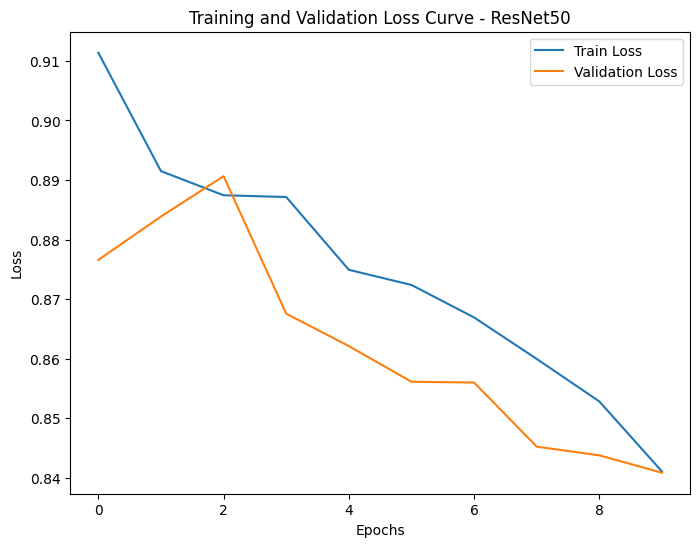

In [15]:
def plot_loss_curve(train_loss, val_loss, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curve - {model_name}')
    plt.legend()
    plt.show()

# Example usage:
plot_loss_curve(train_loss_resnet50, val_loss_resnet50, 'ResNet50')


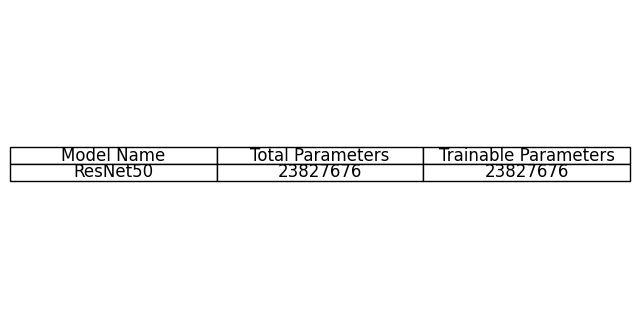

In [16]:
import pandas as pd

# Example data
data = {
    "Model Name": ["ResNet50"],
    "Total Parameters": [sum(p.numel() for p in model_resnet50.parameters())],
    "Trainable Parameters": [sum(p.numel() for p in model_resnet50.parameters() if p.requires_grad)]
}

df = pd.DataFrame(data)

# Plotting the table
plt.figure(figsize=(8, 4))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.show()


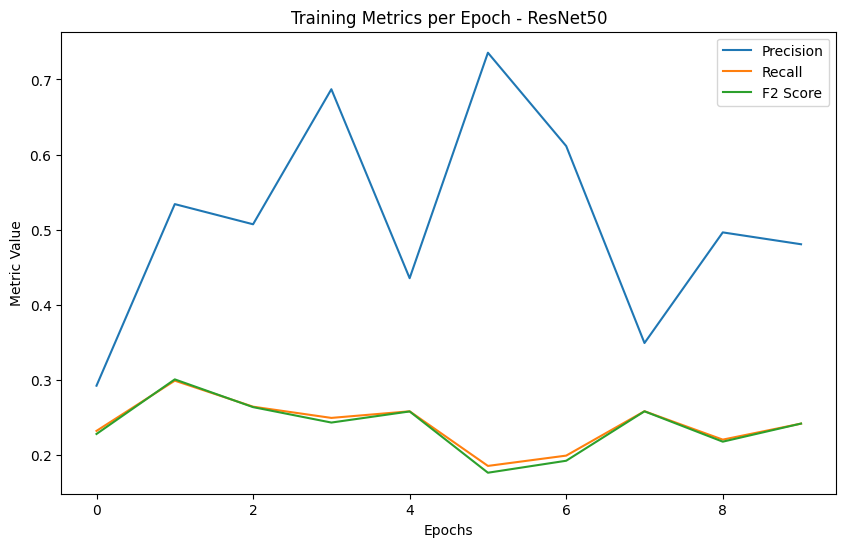

In [19]:
def plot_training_metrics(metrics, model_name):
    plt.figure(figsize=(10, 6))
    # plt.plot(metrics['accuracy'], label='Accuracy')
    plt.plot(metrics['precision'], label='Precision')
    plt.plot(metrics['recall'], label='Recall')
    plt.plot(metrics['f2_score'], label='F2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title(f'Training Metrics per Epoch - {model_name}')
    plt.legend()
    plt.show()

metrics_resnet50 = {
    'accuracy': accuracy_resnet50,
    'precision': precision_resnet50,
    'recall': recall_resnet50,
    'f2_score': f2_score_resnet50
}

# Example usage:
plot_training_metrics(metrics_resnet50, 'ResNet50')


# InceptionV3

In [20]:
import torch.nn as nn
import torchvision.models as models
import torch
from sklearn.metrics import precision_score, recall_score, fbeta_score, accuracy_score
from tqdm import tqdm

# Load the pre-trained InceptionV3 model
model = models.inception_v3(pretrained=True)

# Ensure that all layers are trainable (no layers are frozen)
for param in model.parameters():
    param.requires_grad = True

# InceptionV3 has an auxiliary output during training which we need to modify as well
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 26 * 6)

# Replace the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, 26 * 6)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the optimizer to train all parameters
optimizer = torch.optim.Adam([
    {'params': model.fc.parameters()},
    {'params': model.AuxLogits.fc.parameters()}
], lr=0.001)

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet statistics
])

# Create datasets
train_dataset = RoadDamageDataset(csv_file_or_df=train_data, img_dir=img_dir, damage_columns=damage_columns, transform=transform)
test_dataset = RoadDamageDataset(csv_file_or_df=test_data, img_dir=img_dir, damage_columns=damage_columns, transform=transform)

# DataLoader to handle batching
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Variables to store for later visualization
loss_values_inceptionv3 = []
val_loss_inceptionv3 = []
accuracy_inceptionv3 = []
precision_inceptionv3 = []
recall_inceptionv3 = []
f2_score_inceptionv3 = []

def train_inceptionv3(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    loss_values = []  # To store loss at each epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            if isinstance(outputs, tuple):  # If model outputs both main and auxiliary outputs
                main_outputs, aux_outputs = outputs
                main_outputs = main_outputs.view(-1, 6)  # Flatten to [batch_size * 26, 6]
                aux_outputs = aux_outputs.view(-1, 6)
                labels = labels.view(-1)  # Flatten to [batch_size * 26]

                # Compute loss
                loss1 = criterion(main_outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2  # Combine main and auxiliary loss
            else:
                outputs = outputs.view(-1, 6)
                labels = labels.view(-1)
                loss = criterion(outputs, labels)  # Compute loss only for the main output

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': running_loss / len(dataloader)})

        # Store the loss for this epoch
        epoch_loss = running_loss / len(dataloader)
        loss_values.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Validation after each epoch
        val_loss, val_acc, val_prec, val_rec, val_f2 = evaluate_inceptionv3(model, test_loader)
        val_loss_inceptionv3.append(val_loss)
        accuracy_inceptionv3.append(val_acc)
        precision_inceptionv3.append(val_prec)
        recall_inceptionv3.append(val_rec)
        f2_score_inceptionv3.append(val_f2)

    return loss_values

def evaluate_inceptionv3(model, dataloader):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                main_outputs = outputs[0]
            else:
                main_outputs = outputs

            main_outputs = main_outputs.view(-1, 26, 6)
            _, predicted = torch.max(main_outputs, 2)

            val_loss += criterion(main_outputs.view(-1, 6), labels.view(-1)).item()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_predictions.extend(predicted.cpu().numpy().flatten())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f2 = fbeta_score(all_labels, all_predictions, beta=2, average='macro')

    print(f"Validation Loss: {val_loss / len(dataloader):.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2-Score: {f2:.4f}")

    return val_loss / len(dataloader), accuracy, precision, recall, f2

# Train the model using the train_loader
loss_values_inceptionv3 = train_inceptionv3(model, train_loader, criterion, optimizer, num_epochs=10)

# After training, all the metrics are stored in the respective lists:
metrics_inceptionv3 = {
    'accuracy': accuracy_inceptionv3,
    'precision': precision_inceptionv3,
    'recall': recall_inceptionv3,
    'f2_score': f2_score_inceptionv3,
    'train_loss': loss_values_inceptionv3,
    'val_loss': val_loss_inceptionv3
}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 101/101 [02:05<00:00,  1.24s/it, Loss=1.32]


Epoch [1/10], Loss: 1.3156


Evaluating: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


Validation Loss: 0.8844
Accuracy: 0.6833
Precision: 0.8016
Recall: 0.1847
F2-Score: 0.1758


Epoch 2/10: 100%|██████████| 101/101 [01:58<00:00,  1.18s/it, Loss=0.859]


Epoch [2/10], Loss: 0.8590


Evaluating: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Validation Loss: 0.8659
Accuracy: 0.6888
Precision: 0.4495
Recall: 0.2187
F2-Score: 0.2154


Epoch 3/10: 100%|██████████| 101/101 [01:56<00:00,  1.16s/it, Loss=0.813]


Epoch [3/10], Loss: 0.8134


Evaluating: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Validation Loss: 0.8682
Accuracy: 0.6751
Precision: 0.4358
Recall: 0.3088
F2-Score: 0.3145


Epoch 4/10: 100%|██████████| 101/101 [01:56<00:00,  1.15s/it, Loss=0.778]


Epoch [4/10], Loss: 0.7777


Evaluating: 100%|██████████| 26/26 [00:21<00:00,  1.23it/s]


Validation Loss: 0.8539
Accuracy: 0.6908
Precision: 0.4675
Recall: 0.2628
F2-Score: 0.2688


Epoch 5/10: 100%|██████████| 101/101 [01:57<00:00,  1.16s/it, Loss=0.741]


Epoch [5/10], Loss: 0.7408


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


Validation Loss: 0.8511
Accuracy: 0.6860
Precision: 0.4471
Recall: 0.2880
F2-Score: 0.2944


Epoch 6/10: 100%|██████████| 101/101 [01:56<00:00,  1.15s/it, Loss=0.72]


Epoch [6/10], Loss: 0.7201


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]


Validation Loss: 0.8524
Accuracy: 0.6860
Precision: 0.4490
Recall: 0.3123
F2-Score: 0.3159


Epoch 7/10: 100%|██████████| 101/101 [01:55<00:00,  1.14s/it, Loss=0.694]


Epoch [7/10], Loss: 0.6936


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Validation Loss: 0.8561
Accuracy: 0.6810
Precision: 0.4292
Recall: 0.3244
F2-Score: 0.3312


Epoch 8/10: 100%|██████████| 101/101 [01:53<00:00,  1.12s/it, Loss=0.68]


Epoch [8/10], Loss: 0.6798


Evaluating: 100%|██████████| 26/26 [00:21<00:00,  1.18it/s]


Validation Loss: 0.8495
Accuracy: 0.6792
Precision: 0.4308
Recall: 0.3281
F2-Score: 0.3331


Epoch 9/10: 100%|██████████| 101/101 [01:53<00:00,  1.12s/it, Loss=0.653]


Epoch [9/10], Loss: 0.6527


Evaluating: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Validation Loss: 0.8511
Accuracy: 0.6858
Precision: 0.4585
Recall: 0.2912
F2-Score: 0.2985


Epoch 10/10: 100%|██████████| 101/101 [01:54<00:00,  1.13s/it, Loss=0.637]


Epoch [10/10], Loss: 0.6366


Evaluating: 100%|██████████| 26/26 [00:23<00:00,  1.10it/s]

Validation Loss: 0.8664
Accuracy: 0.6645
Precision: 0.4201
Recall: 0.3506
F2-Score: 0.3547


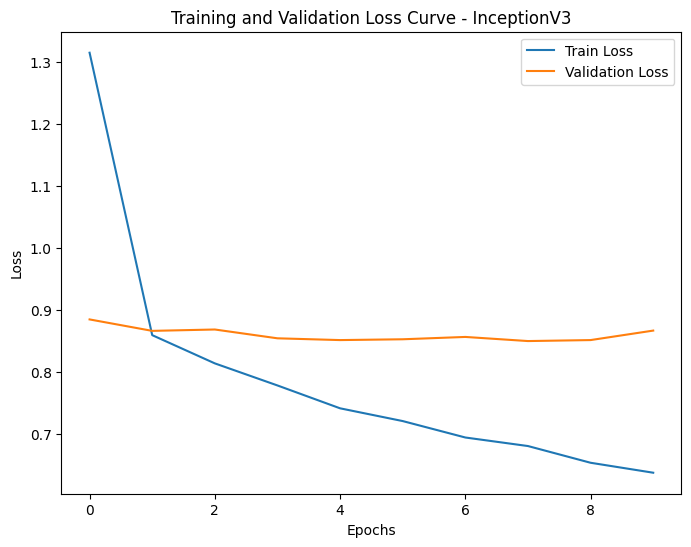

In [21]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_loss, val_loss, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curve - {model_name}')
    plt.legend()
    plt.show()

# Example usage:
plot_loss_curve(metrics_inceptionv3['train_loss'], metrics_inceptionv3['val_loss'], 'InceptionV3')


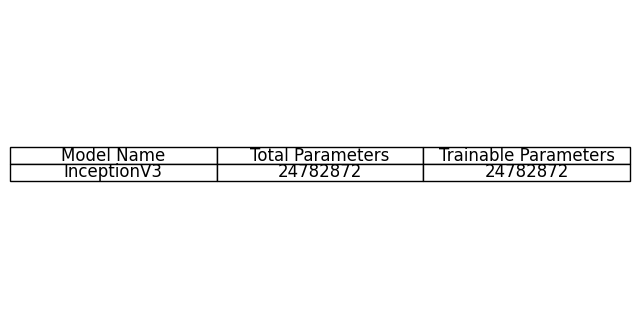

In [26]:
import pandas as pd

def plot_parameters_table(model, model_name):
    # Create the table data
    data = {
        "Model Name": [model_name],
        "Total Parameters": [sum(p.numel() for p in model.parameters())],
        "Trainable Parameters": [sum(p.numel() for p in model.parameters() if p.requires_grad)]
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Plot the table
    plt.figure(figsize=(8, 4))
    plt.axis('tight')
    plt.axis('off')
    table = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.show()

# Example usage:
plot_parameters_table(model, 'InceptionV3')


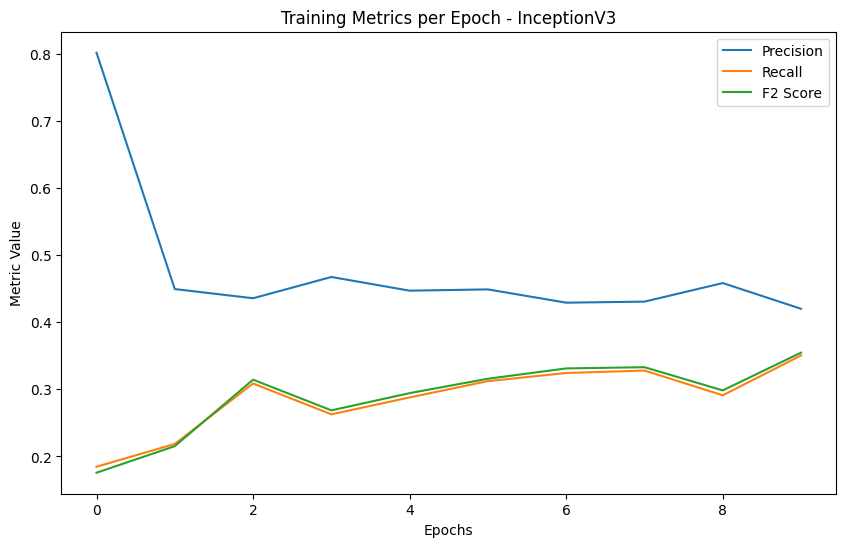

In [22]:
def plot_training_metrics(metrics, model_name):
    plt.figure(figsize=(10, 6))
    # plt.plot(metrics['accuracy'], label='Accuracy')
    plt.plot(metrics['precision'], label='Precision')
    plt.plot(metrics['recall'], label='Recall')
    plt.plot(metrics['f2_score'], label='F2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title(f'Training Metrics per Epoch - {model_name}')
    plt.legend()
    plt.show()

# Example usage:
plot_training_metrics(metrics_inceptionv3, 'InceptionV3')


# VGG16

In [23]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained VGG16 model
model_vgg16 = models.vgg16(pretrained=True)

# Ensure that all layers are trainable (no layers are frozen)
for param in model_vgg16.parameters():
    param.requires_grad = True

# Replace the final fully connected layer to match the output size
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, 26 * 6)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg16 = model_vgg16.to(device)

# Define the optimizer to train all parameters
optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=0.001)

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the size expected by VGG16
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet statistics
])

# Create datasets
train_dataset = RoadDamageDataset(csv_file_or_df=train_data, img_dir=img_dir, damage_columns=damage_columns, transform=transform)
test_dataset = RoadDamageDataset(csv_file_or_df=test_data, img_dir=img_dir, damage_columns=damage_columns, transform=transform)

# DataLoader to handle batching
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Variables to store for later visualization
loss_values_vgg16 = []
val_loss_vgg16 = []
accuracy_vgg16 = []
precision_vgg16 = []
recall_vgg16 = []
f2_score_vgg16 = []

def train_vgg16(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            outputs = outputs.view(-1, 6)  # Flatten to [batch_size * 26, 6]
            labels = labels.view(-1)  # Flatten to [batch_size * 26]

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': running_loss / len(dataloader)})

        # Store the loss for this epoch
        epoch_loss = running_loss / len(dataloader)
        loss_values_vgg16.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Validation after each epoch
        val_loss, val_acc, val_prec, val_rec, val_f2 = evaluate_vgg16(model, test_loader)
        val_loss_vgg16.append(val_loss)
        accuracy_vgg16.append(val_acc)
        precision_vgg16.append(val_prec)
        recall_vgg16.append(val_rec)
        f2_score_vgg16.append(val_f2)

    return loss_values_vgg16

def evaluate_vgg16(model, dataloader):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.view(-1, 26, 6)
            _, predicted = torch.max(outputs, 2)

            val_loss += criterion(outputs.view(-1, 6), labels.view(-1)).item()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_predictions.extend(predicted.cpu().numpy().flatten())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f2 = fbeta_score(all_labels, all_predictions, beta=2, average='macro')

    print(f"Validation Loss: {val_loss / len(dataloader):.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2-Score: {f2:.4f}")

    return val_loss / len(dataloader), accuracy, precision, recall, f2

# Train the model using the train_loader
loss_values_vgg16 = train_vgg16(model_vgg16, train_loader, criterion, optimizer, num_epochs=10)

# After training, all the metrics are stored in the respective lists:
metrics_vgg16 = {
    'accuracy': accuracy_vgg16,
    'precision': precision_vgg16,
    'recall': recall_vgg16,
    'f2_score': f2_score_vgg16,
    'train_loss': loss_values_vgg16,
    'val_loss': val_loss_vgg16
}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 101/101 [01:55<00:00,  1.14s/it, Loss=1.92]


Epoch [1/10], Loss: 1.9207


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]


Validation Loss: 0.8798
Accuracy: 0.6816
Precision: 0.9469
Recall: 0.1667
F2-Score: 0.1524


Epoch 2/10: 100%|██████████| 101/101 [01:55<00:00,  1.14s/it, Loss=0.892]


Epoch [2/10], Loss: 0.8917


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Validation Loss: 0.8839
Accuracy: 0.6769
Precision: 0.7581
Recall: 0.2541
F2-Score: 0.2473


Epoch 3/10: 100%|██████████| 101/101 [01:54<00:00,  1.13s/it, Loss=0.895]


Epoch [3/10], Loss: 0.8953


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Validation Loss: 0.8709
Accuracy: 0.6816
Precision: 0.9469
Recall: 0.1667
F2-Score: 0.1524


Epoch 4/10: 100%|██████████| 101/101 [01:53<00:00,  1.13s/it, Loss=0.889]


Epoch [4/10], Loss: 0.8891


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Validation Loss: 0.8790
Accuracy: 0.6766
Precision: 0.7626
Recall: 0.2558
F2-Score: 0.2493


Epoch 5/10: 100%|██████████| 101/101 [01:56<00:00,  1.15s/it, Loss=0.888]


Epoch [5/10], Loss: 0.8884


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.17it/s]


Validation Loss: 0.8781
Accuracy: 0.6787
Precision: 0.7564
Recall: 0.2447
F2-Score: 0.2353


Epoch 6/10: 100%|██████████| 101/101 [01:54<00:00,  1.14s/it, Loss=0.888]


Epoch [6/10], Loss: 0.8878


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Validation Loss: 0.8705
Accuracy: 0.6816
Precision: 0.9469
Recall: 0.1667
F2-Score: 0.1524


Epoch 7/10: 100%|██████████| 101/101 [01:52<00:00,  1.12s/it, Loss=0.885]


Epoch [7/10], Loss: 0.8847


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Validation Loss: 0.8718
Accuracy: 0.6819
Precision: 0.8622
Recall: 0.2398
F2-Score: 0.2281


Epoch 8/10: 100%|██████████| 101/101 [01:52<00:00,  1.11s/it, Loss=0.887]


Epoch [8/10], Loss: 0.8872


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Validation Loss: 0.8697
Accuracy: 0.6819
Precision: 0.8622
Recall: 0.2398
F2-Score: 0.2281


Epoch 9/10: 100%|██████████| 101/101 [01:53<00:00,  1.12s/it, Loss=0.886]


Epoch [9/10], Loss: 0.8864


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Validation Loss: 0.8694
Accuracy: 0.6816
Precision: 0.9469
Recall: 0.1667
F2-Score: 0.1524


Epoch 10/10: 100%|██████████| 101/101 [01:52<00:00,  1.11s/it, Loss=0.886]


Epoch [10/10], Loss: 0.8861


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]

Validation Loss: 0.8700
Accuracy: 0.6819
Precision: 0.8622
Recall: 0.2398
F2-Score: 0.2281


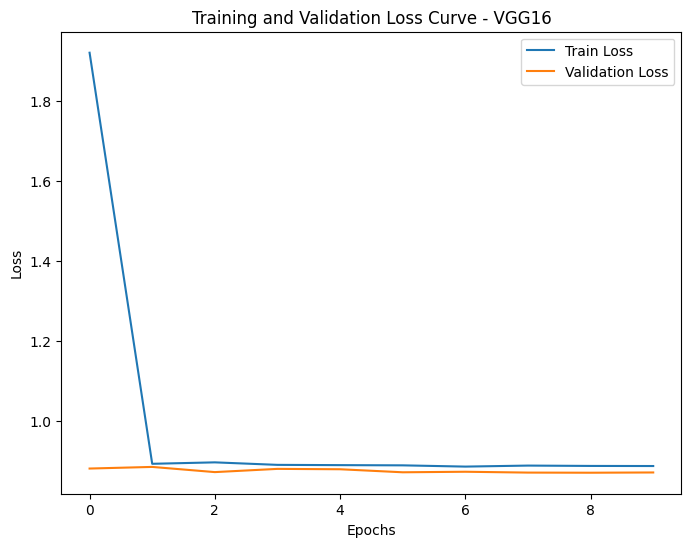

In [24]:
plot_loss_curve(metrics_vgg16['train_loss'], metrics_vgg16['val_loss'], 'VGG16')


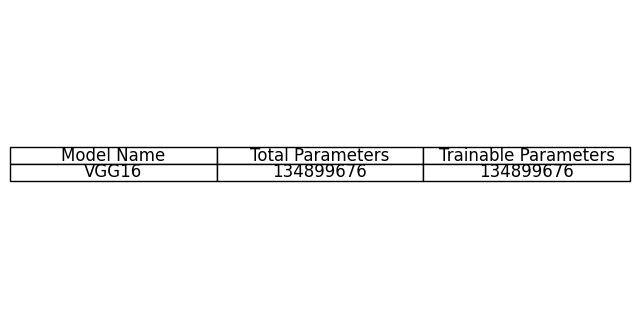

In [27]:
plot_parameters_table(model_vgg16, 'VGG16')


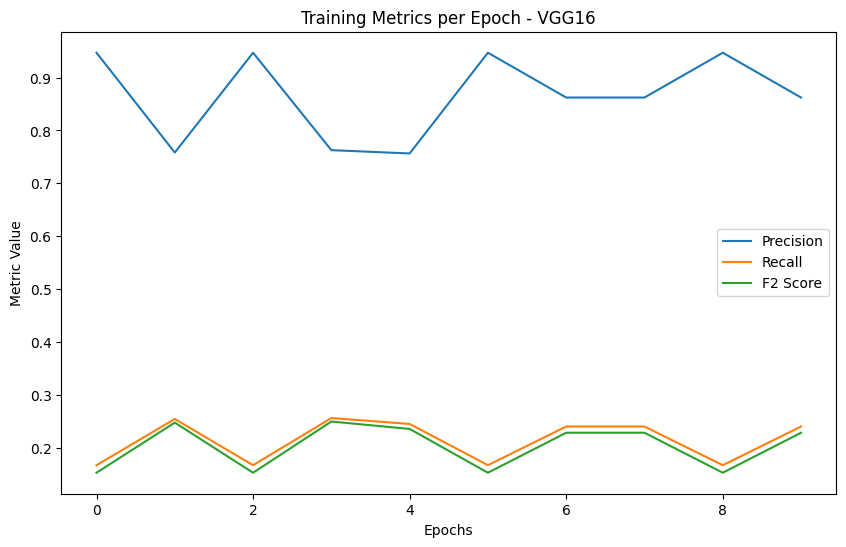

In [28]:
plot_training_metrics(metrics_vgg16, 'VGG16')


# Model Comparisons

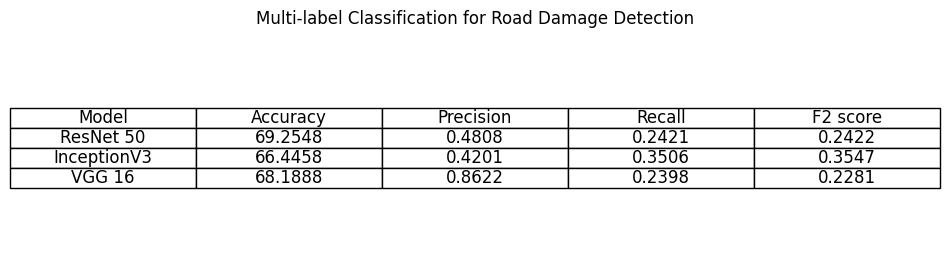

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming ResNet metrics are scalar values
metrics_resnet = {
    'accuracy': round(acc_resnet50, 4),
    'precision': round(prec_resnet50, 4),
    'recall': round(rec_resnet50, 4),
    'f2_score': round(f2_resnet50, 4)
}

# Extract the last value from each list for InceptionV3 and VGG16 metrics and round them
metrics_inceptionv3 = {
    'accuracy': round(accuracy_inceptionv3[-1] * 100, 4),
    'precision': round(precision_inceptionv3[-1], 4),
    'recall': round(recall_inceptionv3[-1], 4),
    'f2_score': round(f2_score_inceptionv3[-1], 4)
}

metrics_vgg16 = {
    'accuracy': round(accuracy_vgg16[-1] * 100, 4),
    'precision': round(precision_vgg16[-1], 4),
    'recall': round(recall_vgg16[-1], 4),
    'f2_score': round(f2_score_vgg16[-1], 4)
}

# Create a DataFrame for easy tabular display
data = {
    "Model": ["ResNet 50", "InceptionV3", "VGG 16"],
    "Accuracy": [metrics_resnet['accuracy'], metrics_inceptionv3['accuracy'], metrics_vgg16['accuracy']],
    "Precision": [metrics_resnet['precision'], metrics_inceptionv3['precision'], metrics_vgg16['precision']],
    "Recall": [metrics_resnet['recall'], metrics_inceptionv3['recall'], metrics_vgg16['recall']],
    "F2 score": [metrics_resnet['f2_score'], metrics_inceptionv3['f2_score'], metrics_vgg16['f2_score']]
}

df = pd.DataFrame(data)

# Plotting the table
plt.figure(figsize=(10, 3))
plt.axis('off')  # Hide the axes

# Create the table
tbl = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Style the table (optional)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)

plt.title("Multi-label Classification for Road Damage Detection")
plt.show()


# Summary
I have trained three models—ResNet50, InceptionV3, and VGG16—using a consistent learning rate of 0.001 and for 15 epochs. This consistency was maintained to ensure fair comparison despite the different training times required due to the varying number of parameters in each model.

# Suggestions to Improve Evaluation Metrics

Train on a Larger Dataset and Experiment with Different Split Ratios:

- The current dataset consists of 4004 TIF images, and with an 80-20 split, approximately 3200 images are used for training. Given that we are dealing with 26 classes, each with 5 labels, this dataset size may be insufficient to fully train the models. Training on a larger dataset would likely result in significant improvements in evaluation metrics. Additionally, experimenting with different train-test split ratios could also yield better results.

Play Around with Hyperparameters and Train for More Epochs:

- Experimenting with different hyperparameters, such as learning rates, batch sizes, and weight decay, could lead to better model performance. Additionally, training the models for more epochs could help in achieving better convergence and improved evaluation metrics. If you are following a specific research paper or architecture, consider reviewing the hyperparameters they used during training, as replicating those settings could yield better results.

### Future Scope:
Layer Unfreezing: Experiment with unfreezing more layers for enhanced model accuracy.
Larger Datasets: Incorporate more data to improve model generalization.
Real-World Deployment: Potential integration into applications for real-time road damage detection.